In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [4]:
export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width(cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

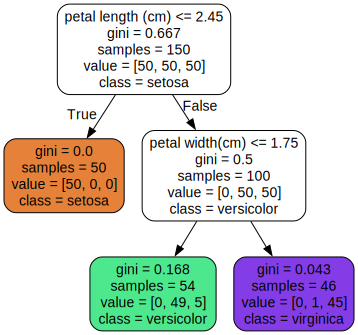

In [5]:
from graphviz import Source

Source.from_file("iris_tree.dot")

The tree is built using the CART algorithm. At the first step, the training set is split into 2 sets that minimises a cost function based on a single feature $k$, and a threshold $t_k$ (eg. petal length < 1.85cm) 

It then keeps doing this as you go down the tree, stopping when the max depth is reached, or no more better predictions can be made.

There are 2 possible cost functions:

* One based on Gini impurity. The Gini impurity is defined as 
$$
G_i = 1=\sum_{k=1}^{n}{p_{i,k}}^2
$$

Where $p_{i,k}$ is the ratio of class $k$ instances incorrectly classified as class $i$ in a given node

The cost function weights the Gini impurity of the 2 child nodes based on the number of instances in those nodes, and adds them up

* One based on entropy. The entropy of a set is 0 when it contains only instances of once class. We define the entropy like in stat mech:

$$
H_i = -\sum_{k=1, p_{i,k}\neq 0 }^n p_{i,k} \log_2{p_{i,k}}
$$

We can regularize (reduce overfitting) decision trees by altering the hyperparameters:

In [6]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [7]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)

tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [8]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

# Regression

Now, instead of minimising the Gini impurity, we instead minimise the MSE

In [9]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.025*np.random.randn(200,1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

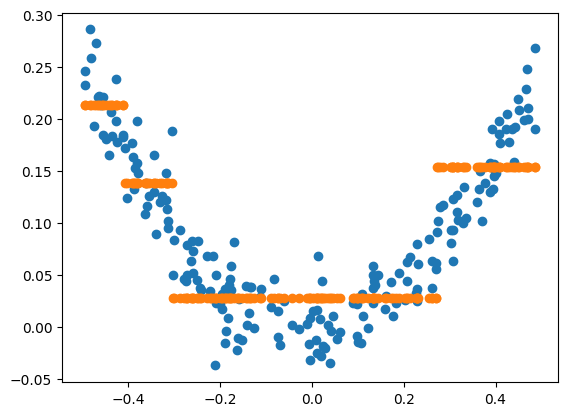

In [11]:
y_predicted = tree_reg.predict(X_quad)

plt.scatter(X_quad, y_quad)
plt.scatter(X_quad, y_predicted)

# Disadvantages:

* Highly sensitive to axis orientations - decision trees use horizontal and vertical barries in parameter space, which is bad when parameters are separated by a 45 degree line

* High variance

# Exercises

# 7
Train and fine-tune a decision tree for the `moons` dataset by following these steps:

Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset.

Use `train_test_split()` to split the dataset into a training set and a test set.

Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly 85% to 87% accuracy.

In [32]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DecisionTreeClassifier()

hyperparams = {
    "max_depth": [2, 4, 6, 8],
    "min_samples_leaf": [10,30,70,100,200,500,1000]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=hyperparams, cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'min_samples_leaf': [10, 30, 70, 100, 200, 500, 1000]})

In [35]:
grid_search.best_params_

{'max_depth': 8, 'min_samples_leaf': 30}

In [36]:
hyperparams = {
    "max_depth": [7, 8, 9, 10, 11],
    "min_samples_leaf": np.arange(10,50,5)
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=hyperparams, cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10, 11],
                         'min_samples_leaf': array([10, 15, 20, 25, 30, 35, 40, 45])})

In [37]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 35}

In [38]:
moons_classifier = grid_search.best_estimator_
moons_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=35)

In [39]:
from sklearn.metrics import accuracy_score

y_pred = moons_classifier.predict(X_test)

accuracy_score(y_test, y_pred)

0.8686666666666667

# 8
Grow a forest by following these steps:

Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn’s `ShuffleSplit` class for this.

Train one decision tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy.

Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction (you can use SciPy’s `mode()` function for this). This approach gives you majority-vote predictions over the test set.

Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a random forest classifier!

In [53]:
X, y = make_moons(10000, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [62]:
from sklearn.model_selection import ShuffleSplit

trees = 1000
instances = 100

splits = []

rs = ShuffleSplit(n_splits=trees, test_size=len(X_train)-instances, random_state=42)

for train_index, test_index in rs.split(X_train):
    splits.append((X_train[train_index], y_train[train_index]))

zip(X_test, y_test)[0][0]

TypeError: 'zip' object is not subscriptable

In [55]:
from sklearn.base import clone
from typing import List

best_tree = grid_search.best_estimator_

tree_classifiers: List[DecisionTreeClassifier] = [clone(best_tree) for _ in splits]

for i, split in enumerate(splits):
    tree_classifiers[i].fit(*split)


In [87]:
# test these individually on the test set

np.mean([accuracy_score(y_test, classifer.predict(X_test)) for classifer in tree_classifiers])

0.7529506666666667

In [68]:
X_test[0]

array([1.85336224, 0.37373425])

In [85]:
# Use a forest to get better results
from scipy.stats import mode

y_pred = []
for i, X_val in enumerate(X_test):
    # print(f"Progress: {(i/len(X_test)*100):.2f}%")
    classifications = [classifer.predict([X_val]) for classifer in tree_classifiers]

    best_estimate = mode(classifications, axis=None, keepdims=False).mode

    y_pred.append(best_estimate)

accuracy_score(y_test, y_pred)


0.77

In [83]:
y_pred[0].mode

0